# Imports

In [63]:
import pandas as pd
from constants import PROJECT_ROOT

# created by: uv run python src/classify_twitter_posts.py --model anthropic/claude-sonnet-4 --temperature 0.1 --n-samples 750 --min-chars 50 --results_filename twitter_posts_classified
dataset_path = (
    f"{PROJECT_ROOT}/outputs/twitter_posts_classified_2025-09-06-H:19-M:31.csv"
)
df = pd.read_csv(dataset_path)
df = df.rename(columns={"biased": "is_antisemitic"})
df["prediction"] = df["prediction"].fillna("None")
df["predicted_antisemitic"] = (
    df["prediction"].isin(
        ["IHRA Definition", "Jerusalem Declaration + IHRA Definition"]
    )
).astype(int)

df.head()

,original_index,text,is_antisemitic,keyword,prediction,description,model,max_tokens,temperature,usage,predicted_antisemitic
0,5310,RT : A core part of my Jewish education growi...,0,Jews,None,This text expresses a Jewish person's perspect...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4774, 'completion_tokens': 7...",0
1,838,President DELIVERS yet another breakthrough f...,0,Israel,None,This text celebrates a diplomatic achievement ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4772, 'completion_tokens': 6...",0
2,3518,Totally creepy. Deep down think they hate Jews...,0,Jews,None,The text expresses suspicion about a group's m...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4756, 'completion_tokens': 7...",0
3,1333,U.S. Virgin Islands (????)\n+\nIsrael (????)\...,0,Israel,None,This appears to be a simple wordplay or pun co...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4762, 'completion_tokens': 9...",0
4,5843,Very distressing but not surprising considerin...,0,Jews,None,The text expresses concern about antisemitism ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4764, 'completion_tokens': 6...",0


# Data Config:
- model: anthropic/claude-sonnet-4 
- temperature 0.1 
- n-samples 750
- min-chars 50 
- Antisemitism samples: 525
- Non-Antisemitism samples: 225

# Cost

In [64]:
import json
import pandas as pd
import ast


# Try different parsing methods
def safe_parse_usage(usage_str):
    try:
        # Try JSON first
        return json.loads(usage_str)
    except Exception:
        try:
            # Try ast.literal_eval for Python dict strings
            return ast.literal_eval(usage_str)
        except Exception:
            try:
                # Try eval as last resort (if it's a Python dict)
                return eval(usage_str)
            except Exception:
                return None


# Parse the usage column
df["usage_parsed"] = df["usage"].apply(safe_parse_usage)

# Check how many failed to parse
failed_count = df["usage_parsed"].isnull().sum()
print(f"Failed to parse: {failed_count} rows out of {len(df)}")

# Extract token counts (handle None values)
df["prompt_tokens"] = df["usage_parsed"].apply(lambda x: x["prompt_tokens"] if x else 0)
df["completion_tokens"] = df["usage_parsed"].apply(
    lambda x: x["completion_tokens"] if x else 0
)
df["total_tokens"] = df["usage_parsed"].apply(lambda x: x["total_tokens"] if x else 0)

# Calculate totals
total_prompt_tokens = df["prompt_tokens"].sum()
total_completion_tokens = df["completion_tokens"].sum()
total_tokens = df["total_tokens"].sum()

# Claude Sonnet 4 pricing: $3/M input, $15/M output
input_cost = (total_prompt_tokens / 1_000_000) * 3
output_cost = (total_completion_tokens / 1_000_000) * 15
total_cost = input_cost + output_cost

print(f"Total Prompt Tokens: {total_prompt_tokens:,}")
print(f"Total Completion Tokens: {total_completion_tokens:,}")
print(f"Total Tokens: {total_tokens:,}")
print("\nCost Breakdown:")
print(f"Input Cost: ${input_cost:.4f}")
print(f"Output Cost: ${output_cost:.4f}")
print(f"Total Cost: ${total_cost:.4f}")

# Also show per-row statistics
print("\nPer-row averages:")
print(f"Avg prompt tokens: {total_prompt_tokens / len(df):.1f}")
print(f"Avg completion tokens: {total_completion_tokens / len(df):.1f}")
print(f"Avg cost per row: ${total_cost / len(df):.4f}")

Failed to parse: 1 rows out of 750
Total Prompt Tokens: 3,572,984
Total Completion Tokens: 63,256
Total Tokens: 3,636,240

Cost Breakdown:
Input Cost: $10.7190
Output Cost: $0.9488
Total Cost: $11.6678

Per-row averages:
Avg prompt tokens: 4764.0
Avg completion tokens: 84.3
Avg cost per row: $0.0156


# EDA

In [65]:
df["prediction"].value_counts()

prediction
IHRA Definition                            381
None                                       316
Jerusalem Declaration + IHRA Definition     52
LLM_ERROR                                    1
Name: count, dtype: int64

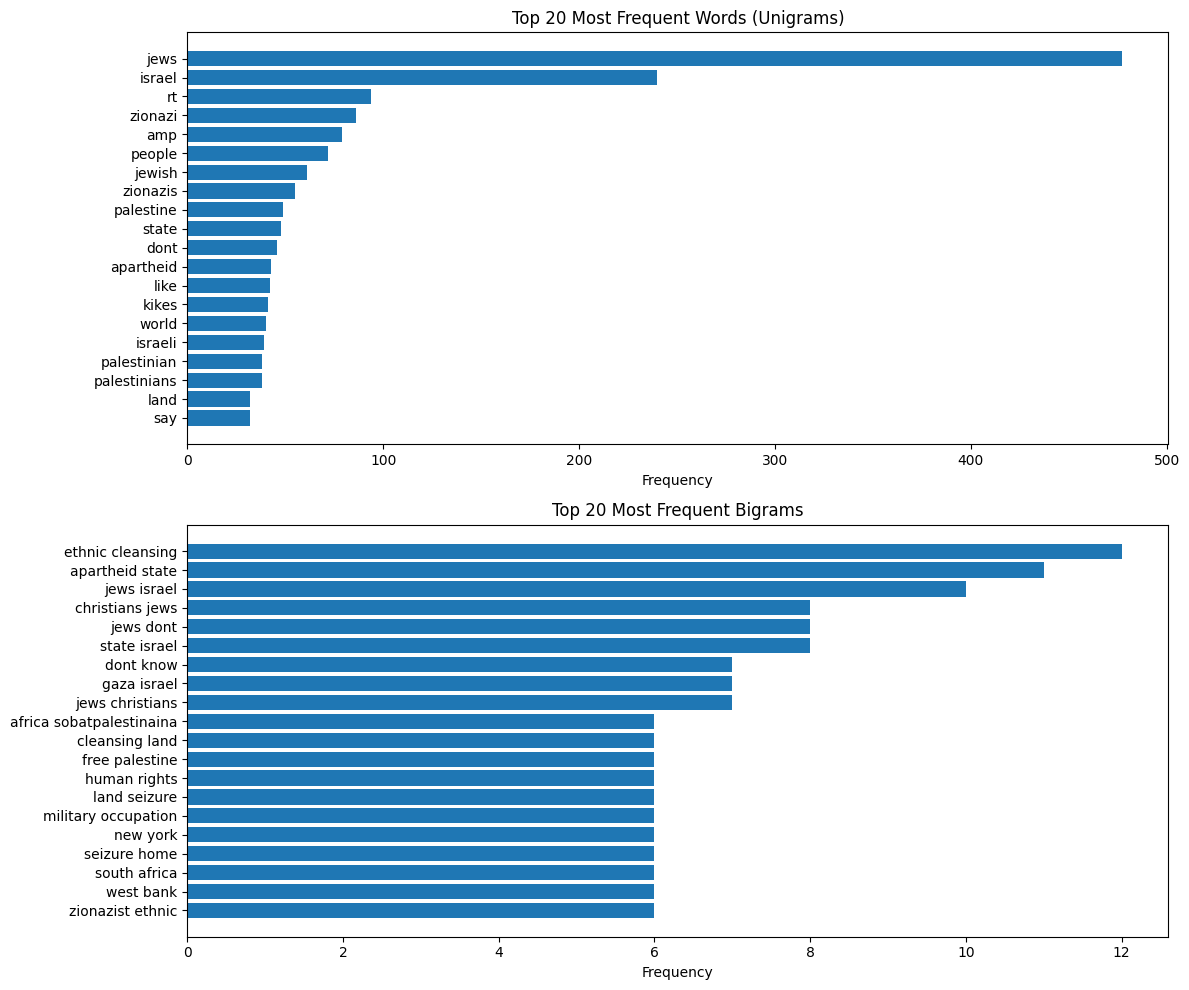

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer


# Clean and prepare text data
def clean_text(text):
    # Convert to lowercase, remove URLs, mentions, and special characters
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()


# Clean all text
df["text_clean"] = df["text"].apply(clean_text)

# Get most frequent words (unigrams)
vectorizer_unigrams = CountVectorizer(
    stop_words="english", max_features=20, ngram_range=(1, 1)
)
unigram_matrix = vectorizer_unigrams.fit_transform(df["text_clean"])
unigram_counts = unigram_matrix.sum(axis=0).A1
unigram_freq = [
    (word, count)
    for word, count in zip(vectorizer_unigrams.get_feature_names_out(), unigram_counts)
]
unigram_freq = sorted(unigram_freq, key=lambda x: x[1], reverse=True)

# Get most frequent bigrams
vectorizer_bigrams = CountVectorizer(
    stop_words="english", max_features=20, ngram_range=(2, 2)
)
bigram_matrix = vectorizer_bigrams.fit_transform(df["text_clean"])
bigram_counts = bigram_matrix.sum(axis=0).A1
bigram_freq = [
    (word, count)
    for word, count in zip(vectorizer_bigrams.get_feature_names_out(), bigram_counts)
]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot unigrams
words, counts = zip(*unigram_freq)
ax1.barh(range(len(words)), counts)
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.set_xlabel("Frequency")
ax1.set_title("Top 20 Most Frequent Words (Unigrams)")
ax1.invert_yaxis()

# Plot bigrams
bigrams, bigram_counts = zip(*bigram_freq)
ax2.barh(range(len(bigrams)), bigram_counts)
ax2.set_yticks(range(len(bigrams)))
ax2.set_yticklabels(bigrams)
ax2.set_xlabel("Frequency")
ax2.set_title("Top 20 Most Frequent Bigrams")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Prediction stats
A reminder, we gave the LLM the following prompt:
SYSTEM_PROMPT = ```
You are a careful text classifier.

You will be given:
- a JSON object named "annotations" mapping names to definitions (IHRA Definition, Jerusalem Declaration)
- a "text" string to classify
The definitions are different definitions of antisemitism.
The Jerusalem Declaration is a subclass of the IHRA Definition.
Task:
- You should pick the definition that best fits the text.
- The optional labels are: "IHRA Definition", "Jerusalem Declaration + IHRA Definition", "None" (not antisemitic). 
- Pick exactly one label.
- If several could fit, choose the stricter or more specific one.
- Output JSON only, no extra words.

Output schema:
{
  "answer": "<one key from annotations>",
  "description": "<1 to 3 sentences explaining the choice>"
}

Rules:
- answer MUST be exactly one of optional labels: "IHRA Definition", "Jerusalem Declaration + IHRA Definition", "None".
- description must cite concrete cues from the text
```

USER_PROMPT =  ```"annotations:\n"
        + <ANNOTATIONS GUIDELINES>
        + "\n\ntext:\n"
        + text
        + "\n\nRespond with JSON only matching the schema."
        ```

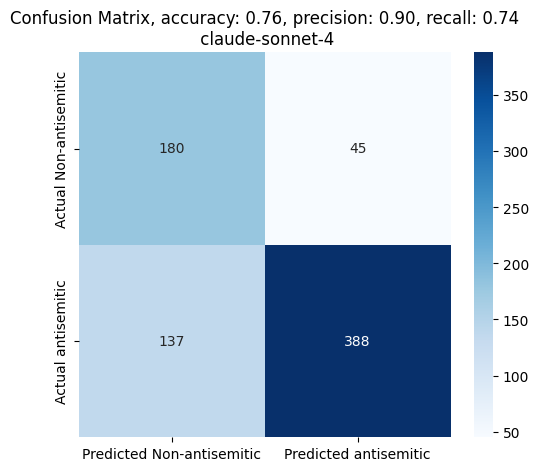

In [67]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
)
import matplotlib.pyplot as plt

cm = confusion_matrix(df["is_antisemitic"], df["predicted_antisemitic"])
precision = precision_score(df["is_antisemitic"], df["predicted_antisemitic"])
recall = recall_score(df["is_antisemitic"], df["predicted_antisemitic"])
accuracy = accuracy_score(df["is_antisemitic"], df["predicted_antisemitic"])

selected_model = df["model"].unique()[0]
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Non-antisemitic", "Predicted antisemitic"],
    yticklabels=["Actual Non-antisemitic", "Actual antisemitic"],
)
plt.title(
    f"Confusion Matrix, accuracy: {accuracy:.2f}, precision: {precision:.2f}, recall: {recall:.2f}\n {selected_model.split('/')[-1]}"
)
plt.show()

Its a decent accuracy for a one shot classification. There are some hard posts to classify, mainly becuase we don't have the context (who is the user, a lot of the posts have images which helped the taggers to tag, etc). 
Let's look where the LLM classifier was wrong:

Note! I removed the usernames from the text, but i can restore them for our manual tagging. (if it will helps)

In [68]:
columns = [
    "text",
    "is_antisemitic",
    "predicted_antisemitic",
    "prediction",
    "description",
]
false_positives = df[(df["predicted_antisemitic"] == 1) & (df["is_antisemitic"] == 0)][
    columns
]
false_negatives = df[(df["predicted_antisemitic"] == 0) & (df["is_antisemitic"] == 1)][
    columns
]
true_positives = df[(df["predicted_antisemitic"] == 1) & (df["is_antisemitic"] == 1)][
    columns
]
true_negatives = df[(df["predicted_antisemitic"] == 0) & (df["is_antisemitic"] == 0)][
    columns
]

In [69]:
from itables import show
import itables.options as opt
from IPython.display import HTML, display

opt.classes = ["display", "cell-border", "compact"]


display(
    HTML("""
<style>
table.dataTable { table-layout: fixed; }               /* column widths are respected */
table.dataTable td { white-space: normal;              /* allow wrapping */
                     word-break: break-word;           /* break long tokens */
                     overflow-wrap: anywhere; }
</style>
""")
)


opt.autoWidth = False
coldefs = [{"width": "280px", "targets": "_all"}]


opt.lengthMenu = [10, 25, 50, 100]
opt.maxBytes = 0

In [70]:
show(false_positives, caption="False Positives")

Loading ITables v2.5.2 from the internet... (need help?)


In [71]:
show(false_negatives, caption="False Negatives")

Loading ITables v2.5.2 from the internet... (need help?)


In [72]:
show(true_positives, caption="True Positives")

Loading ITables v2.5.2 from the internet... (need help?)


In [73]:
show(true_negatives, caption="True Negatives")

Loading ITables v2.5.2 from the internet... (need help?)


# Only IHRA

In [75]:
IHRA_df = pd.read_csv(
    f"{PROJECT_ROOT}/outputs/twitter_posts_classified_IHRA_2025-09-07-H:09-M:51.csv"
)
IHRA_df

,original_index,text,biased,keyword,prediction,description,model,max_tokens,temperature,usage
0,5310,RT : A core part of my Jewish education growi...,0,Jews,False,This text expresses criticism of Israeli polic...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 2614, 'completion_tokens': 6..."
1,3910,Lol y'all still in denial about who the true J...,1,Jews,True,This text promotes the antisemitic conspiracy ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 2581, 'completion_tokens': 8..."
2,5350,"So far from what I’ve read, I’ve gathered that...",1,Jews,False,This text presents a historical observation ab...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 2600, 'completion_tokens': 8..."
3,6764,"The anti neoliberal, anti ZioNazi forces every...",1,ZioNazi,True,The text uses the term 'ZioNazi' which combine...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 2609, 'completion_tokens': 9..."
